# Amazon SageMaker Object Detection using the Image and JSON format

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data Preparation](#Data-Preparation)
  1. [Download data](#Download-Data)
  2. [Prepare Dataset](#Prepare-dataset)
  3. [Upload to S3](#Upload-to-S3)
4. [Training](#Training)
5. [Hosting](#Hosting)
6. [Inference](#Inference)

## Introduction

Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes in an image as input and provides a bounding box on the image where an object of interest is, along with identifying what object the box encapsulates. But before we have this solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that the aglorithm can learn about the dataset and then host the algorithm as an endpoint, to which we can supply the query image.

This notebook is an end-to-end example introducing the Amazon SageMaker Object Detection algorithm. In this demo, we will demonstrate how to train and to host an object detection model on the [COCO dataset](http://cocodataset.org/) using the Single Shot multibox Detector ([SSD](https://arxiv.org/abs/1512.02325)) algorithm. In doing so, we will also demonstrate how to construct a training dataset using the JSON format as this is the format that the training job will consume. We also allow the RecordIO format, which is illustrated in the [RecordIO Notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb). We will also demonstrate how to host and validate this trained model.

## Setup

To train the Object Detection algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with we need an AWS account role with SageMaker access. This role is used to give SageMaker access to your data in S3 will automatically be obtained from the role used to start the notebook.

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::476271697919:role/app-sagemaker-execution-role
CPU times: user 881 ms, sys: 159 ms, total: 1.04 s
Wall time: 9.49 s


We also need the S3 bucket that you want to use for training and to store the tranied model artifacts. In this notebook, we require a custom bucket that exists so as to keep the naming clean. You can end up using a default bucket that SageMaker comes with as well.

In [2]:
bucket = 'beyoung-sagemaker' # custom bucket name.
# bucket = sess.default_bucket()
prefix = 'coco-object-detection-20200422'

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

433757028032.dkr.ecr.us-west-2.amazonaws.com/object-detection:latest


## Data Preparation
[MS COCO](http://cocodataset.org/#download) is a large-scale dataset for multiple computer vision tasks, including object detection, segmentation, and captioning. In this notebook, we will use the object detection dataset. Since the COCO is relative large dataset, we will only use the the validation set from 2017 and split them into training and validation sets. The data set from 2017 contains 5000 images with objects from 80 categories.

### Datset License
The annotations in this dataset belong to the COCO Consortium and are licensed under a Creative Commons Attribution 4.0 License. The COCO Consortium does not own the copyright of the images. Use of the images must abide by the Flickr Terms of Use. The users of the images accept full responsibility for the use of the dataset, including but not limited to the use of any copies of copyrighted images that they may create from the dataset. Before you use this data for any other purpose than this example, you should understand the data license, described at http://cocodataset.org/#termsofuse"

### Download data
Let us download the 2017 validation datasets from COCO and then unpack them.

In [4]:
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)


# MSCOCO validation image files
download('http://images.cocodataset.org/zips/val2017.zip')
download('http://images.cocodataset.org/annotations/annotations_trainval2017.zip')

In [5]:
%%bash
unzip -qo val2017.zip
unzip -qo annotations_trainval2017.zip
rm val2017.zip annotations_trainval2017.zip

Before using this dataset, we need to perform some data cleaning. The algorithm expects the dataset in a particular JSON format. The COCO dataset, while containing annotations in JSON, does not follow our specifications. We will use this as an opportunity to introduce our JSON format by performing this convertion. To begin with we create appropriate directories for training images, validation images, as well as the annotation files for both.

In [6]:
%%bash
#Create folders to store the data and annotation files
mkdir generated train train_annotation validation validation_annotation

## folder explaination
* generated: temperay workding folder
* train: training images source
* train_annotation: annotation files
* validation: validation images
* validation_annotation: anotation file for validation

# Explore Coco dataset

In [7]:
!ls ./annotations

captions_train2017.json   instances_val2017.json
captions_val2017.json	  person_keypoints_train2017.json
instances_train2017.json  person_keypoints_val2017.json


### Prepare dataset 

Next, we should convert the annotation file from the COCO dataset into json annotation files. We will require one annotation for each image.

The Amazon SageMaker Object Detection algorithm expects lables to be indexed from `0`. It also expects lables to be unique, successive and not skip any integers. For instance, if there are ten classes, the algorithm expects and the labels only be in the set `[0,1,2,3,4,5,6,7,8,9]`. 

In the COCO validation set unfortunately, the labels do not satistify this requirement. Some indices are skipped and the labels start from `1`. We therefore need a mapper that will convert this index system to our requirement. Let us create a generic mapper therefore that could also be used to other datasets that might have nonunique or even string labels. All we need in a dictionary that would create a key-value mapping where an original label is hashed to a label that we require. Consider the following method that returns such a dictionary for the COCO validation dataset.

## COCO Data Set Explore

* [coco explore](http://cocodataset.org/#explore)
* coco data set format [link](http://cocodataset.org/#format-data)
* 80 categories [mapping](https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/)

In [9]:
object_categories = ['person', 'bicycle', 'car',  'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 
                     'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                     'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
                     'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                     'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                     'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                     'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable',
                     'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                     'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
                     'toothbrush']
len(object_categories)

80

In [10]:
import json
import logging

def get_coco_mapper():
    original_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
                    21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                    41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
                    61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80,
                    81, 82, 84, 85, 86, 87, 88, 89, 90]
    iter_counter = 0
    COCO = {}
    for orig in original_list:
        COCO[orig] = iter_counter
        iter_counter += 1
    return COCO

In [11]:
## Coco category "60" -> mapping to training category 54
mapper_coco = get_coco_mapper()
mapper_coco[60]

54

Let us use this dictionary, to create a look up method. Let us do so in a way that any dictionary could be used to create this method.

In [12]:
def get_mapper_fn(map):  
    def mapper(in_category):
        return map[in_category]
    return mapper

fix_index_mapping = get_mapper_fn(get_coco_mapper())

In [13]:
fix_index_mapping(60)

54

The method `fix_index_mapping` is essentially a look-up method, which we can use to convert lables. Let us now iterate over every annotation in the COCO dataset and prepare our data. Note how the keywords are created and a structure is established. For more information on the JSON format details, refer the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).

## Train with the Image Format

In [14]:
file_name = './annotations/instances_val2017.json'
with open(file_name) as f:
    js = json.load(f)
    images = js['images']
    categories = js['categories']
    annotations = js['annotations']
    for i in images:
        jsonFile = i['file_name']
        jsonFile = jsonFile.split('.')[0]+'.json'
        
        line = {}
        line['file'] = i['file_name']
        line['image_size'] = [{
            'width':int(i['width']),
            'height':int(i['height']),
            'depth':3
        }]
        line['annotations'] = []
        line['categories'] = []
        for j in annotations:
            if j['image_id'] == i['id'] and len(j['bbox']) > 0:
                line['annotations'].append({
                    'class_id':int(fix_index_mapping(j['category_id'])),
                    'top':int(j['bbox'][1]),
                    'left':int(j['bbox'][0]),
                    'width':int(j['bbox'][2]),
                    'height':int(j['bbox'][3])
                })
                class_name = ''
                for k in categories:
                    if int(j['category_id']) == k['id']:
                        class_name = str(k['name'])
                assert class_name is not ''
                line['categories'].append({
                    'class_id':int(j['category_id']),
                    'name':class_name
                })
        if line['annotations']:
            with open(os.path.join('generated', jsonFile),'w') as p:
                json.dump(line,p)

In [15]:
import os
import json
jsons = os.listdir('generated')

print ('There are {} images have annotation files'.format(len(jsons)))

There are 4952 images have annotation files


In [19]:
print('sample file: {} \n'.format(jsons[0]))
!cat ./generated/{jsons[0]}

sample file: 000000183648.json 

{"file": "000000183648.jpg", "image_size": [{"width": 640, "height": 428, "depth": 3}], "annotations": [{"class_id": 0, "top": 179, "left": 455, "width": 117, "height": 248}, {"class_id": 0, "top": 197, "left": 194, "width": 174, "height": 230}, {"class_id": 0, "top": 209, "left": 117, "width": 137, "height": 211}, {"class_id": 20, "top": 0, "left": 0, "width": 572, "height": 428}], "categories": [{"class_id": 1, "name": "person"}, {"class_id": 1, "name": "person"}, {"class_id": 1, "name": "person"}, {"class_id": 22, "name": "elephant"}]}

## Display file with annotation

In [20]:
from matplotlib import image as image_plt
from matplotlib import pyplot as plt

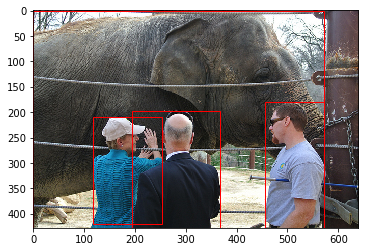

In [31]:
fp = './generated/' + (jsons[0])
with open(fp) as f:
    js = json.load(f)
    img_fp = './val2017/' + js['file']
    im_plt = image_plt.imread(img_fp)
    plt.imshow(im_plt)
    
    annotations = js['annotations']
    for i in annotations:
        left, top, width, height = i['left'], i['top'], i['width'], i['height']
        bbox = plt.Rectangle((left, top), width, height, fill=False, edgecolor=(1,0,0), linewidth=1)
        plt.gca().add_patch(bbox)
    plt.show()

## Split Training and Validation

After removing the images without annotations, we have 4952 annotated images. Let us split this dataset and create our training and validation datasets, with which our algorithm will train. To do so, we will simply split the dataset into training and validation data and move them to their respective folders.

In [32]:
import shutil
train_jsons = jsons[:4452]
val_jsons = jsons[4452:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './val2017/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './train/')
    shutil.move('./generated/'+i, './train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './val2017/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './validation/')
    shutil.move('./generated/'+i, './validation_annotation/')

In [33]:
!cat ./train_annotation/{train_jsons[0]}

{"file": "000000183648.jpg", "image_size": [{"width": 640, "height": 428, "depth": 3}], "annotations": [{"class_id": 0, "top": 179, "left": 455, "width": 117, "height": 248}, {"class_id": 0, "top": 197, "left": 194, "width": 174, "height": 230}, {"class_id": 0, "top": 209, "left": 117, "width": 137, "height": 211}, {"class_id": 20, "top": 0, "left": 0, "width": 572, "height": 428}], "categories": [{"class_id": 1, "name": "person"}, {"class_id": 1, "name": "person"}, {"class_id": 1, "name": "person"}, {"class_id": 22, "name": "elephant"}]}

### Upload to S3
Next step in this process is to upload the data to the S3 bucket, from which the algorithm can read and use the data. We do this using multiple channels. Channels are simply directories in the bucket that differentiate between training and validation data. Let us simply call these directories `train` and `validation`. We will therefore require four channels: two for the data and two for annotations, the annotations ones named with the suffixes `_annotation`.

In [35]:
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

In [36]:
%%time
sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel)

CPU times: user 31.2 s, sys: 3.77 s, total: 35 s
Wall time: 6min 53s


's3://beyoung-sagemaker/coco-object-detection-20200422/train'

In [38]:
%%time
sess.upload_data(path='validation', bucket=bucket, key_prefix=validation_channel)

CPU times: user 3.47 s, sys: 428 ms, total: 3.89 s
Wall time: 46.9 s


's3://beyoung-sagemaker/coco-object-detection-20200422/validation'

In [37]:
%%time
sess.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

CPU times: user 31.8 s, sys: 2.16 s, total: 34 s
Wall time: 4min 12s


In [39]:
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

In [ ]:
# %%time

# train_channel = prefix + '/train'
# validation_channel = prefix + '/validation'
# train_annotation_channel = prefix + '/train_annotation'
# validation_annotation_channel = prefix + '/validation_annotation'

# sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel)
# sess.upload_data(path='validation', bucket=bucket, key_prefix=validation_channel)
# sess.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
# sess.upload_data(path='validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

# s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
# s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
# s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
# s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [40]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [41]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `30` epochs.

In [42]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=80,
                             mini_batch_size=16,
                             epochs=30,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=600,
                             num_training_samples=4452)

Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes. Notice that here we use a `content_type` as `image/jpeg` for the image channels and the annoation channels. Notice how unlike the [RecordIO format](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb), we use four channels here.

In [43]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following cell will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [ ]:
# if error, need to change the instance to ml.p2.xlarge in the estimator
od_model.train_instance_type = 'ml.p2.xlarge'

In [44]:
od_model.fit(inputs=data_channels, logs=True, wait=False)

In [45]:
job_name = od_model.latest_training_job.job_name
job_name

'object-detection-2020-04-22-09-25-36-709'

In [47]:
import boto3, time

sm = boto3.client('sagemaker')
status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']

while status == 'InProgress':
    status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)
    time.sleep(30)

## Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment can be accomplished as follows:

In [48]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge', wait=False)

## Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, let us download an image from [PEXELS](https://www.pexels.com/) which the algorithm has so-far not seen. 

In [ ]:
!wget -O test.jpg --user-agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:21.0) Gecko/20100101 Firefox/21.0" https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg

In [76]:
file_name = 'dog.jpg'
!wget -O {file_name} https://live.staticflickr.com/4106/5052728523_010830b44e_k_d.jpg

--2020-04-22 10:58:12--  https://live.staticflickr.com/4106/5052728523_010830b44e_k_d.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 13.224.26.167, 2600:9000:2196:fa00:0:5a51:64c9:c681, 2600:9000:2196:aa00:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|13.224.26.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg                 [ <=>                ] 934.65K  --.-KB/s    in 0.07s   

2020-04-22 10:58:13 (13.9 MB/s) - ‘dog.jpg’ saved [957084]



In [77]:
with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

Let us use our endpoint to try to detect objects within this image. Since the image is `jpeg`, we use the appropriate `content_type` to run the prediction job. The endpoint returns a JSON file that we can simply load and peek into.

In [78]:
import json

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
print (detections)

{'prediction': [[0.0, 0.5216836929321289, 0.7248553037643433, 0.0, 0.9101921319961548, 0.5743014812469482], [0.0, 0.40109360218048096, 0.35489267110824585, 0.010451078414916992, 0.46446943283081055, 0.5140072703361511], [16.0, 0.32865840196609497, 0.1268599033355713, 0.448965847492218, 0.34719207882881165, 0.7078058123588562], [0.0, 0.298378586769104, 0.33494049310684204, 0.03336319327354431, 0.5148382782936096, 0.6981184482574463], [0.0, 0.24295048415660858, 0.2437889277935028, 0.07200086116790771, 0.28586992621421814, 0.18352320790290833], [0.0, 0.2186928540468216, 0.38019829988479614, 0.07251820713281631, 0.4525318741798401, 0.2169198989868164], [0.0, 0.2067497819662094, 0.4788758456707001, 0.08305148780345917, 0.5016927123069763, 0.17753876745700836], [0.0, 0.19923844933509827, 0.3439202308654785, 0.06613600999116898, 0.3684437870979309, 0.17461270093917847], [0.0, 0.19336262345314026, 0.40759506821632385, 0.01592092216014862, 0.507192850112915, 0.4620388150215149], [0.0, 0.1928678

The results are in a format that is similar to the input .lst file (See [RecordIO Notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) for more details on the .lst file definition. )with an addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [79]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=1)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.savefig('result.jpg', dpi=500)
        plt.show()

For the sake of this notebook, we used a small portion of the COCO dataset for training and trained the model with only a few (30) epochs. This implies that the results might not be optimal. To achieve better detection results, you can try to use the more data from COCO dataset and train the model for more epochs. Tuning the hyperparameters, such as `mini_batch_size`, `learning_rate`, and `optimizer`, also helps to get a better detector.

In [67]:
object_categories = ['person', 'bicycle', 'car',  'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 
                     'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                     'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
                     'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                     'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                     'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                     'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable',
                     'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                     'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
                     'toothbrush']


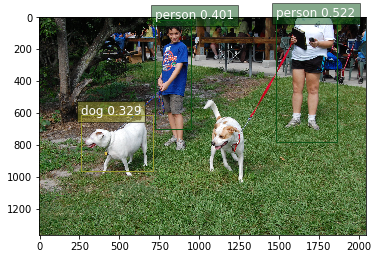

In [85]:
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.30
# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [86]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)